### Visualizations of the rewired Schneider-Mizell compatible SM-connectome

In [1]:
import matplotlib.pyplot as plt
import neurom as nm
import numpy as np
import pandas as pd
import os
import pickle

from bluepysnap import Circuit
from bluepysnap.morph import MorphHelper

In [2]:
output_path = './raw/sm-connectome'

#### Synapse positions on dendritic morphologies before anf after rewiring

In [3]:
figs_path = os.path.join(output_path, 'morphologies')
if not os.path.exists(figs_path):
    os.makedirs(figs_path)

In [4]:
circuit = Circuit('/gpfs/bbp.cscs.ch/project/proj83/jira-tickets/NSETM-1948-extract-hex-O1/data/O1_data/circuit_config.json')
nodes = circuit.nodes['S1nonbarrel_neurons']
edges = circuit.edges['S1nonbarrel_neurons__S1nonbarrel_neurons__chemical']

sm_circuit = Circuit('/gpfs/bbp.cscs.ch/project/proj83/home/pokorny/InterneuronRewiringO1/circuits/SSCx-HexO1-Release__O1_Schneider_Mizell_v2/circuit_config_reparam_tc.json')
sm_nodes = sm_circuit.nodes['S1nonbarrel_neurons']
sm_edges = sm_circuit.edges['S1nonbarrel_neurons__S1nonbarrel_neurons__chemical']

In [5]:
src_types = ['L1_DAC', 'L1_HAC', 'L1_LAC', 'L1_NGC-DA', 'L1_NGC-SA', 'L1_SAC', 'L23_BTC', 'L23_LBC', 'L23_NBC', 'L23_NGC', 'L23_SBC', 'L4_BTC', 'L4_LBC', 'L4_NBC', 'L4_NGC', 'L4_SBC', 'L5_BTC', 'L5_LBC', 'L5_NBC', 'L5_NGC', 'L5_SBC', 'L6_BTC', 'L6_LBC', 'L6_NBC', 'L6_NGC', 'L6_SBC']
src_nids = nodes.ids({'mtype': src_types})
assert np.array_equal(src_nids, sm_nodes.ids({'mtype': src_types}))
tgt_types = list(nodes.property_values('mtype'))
tgt_nids = nodes.ids({'mtype': tgt_types})
assert np.array_equal(tgt_nids, sm_nodes.ids({'mtype': tgt_types}))

In [6]:
ntypes_d = {
    "DistTC": [ # MC, BP, DBC
                "L23_MC", "L4_MC", "L5_MC", "L6_MC",
                "L23_BP", "L4_BP", "L5_BP", "L6_BP",
                "L23_DBC", "L4_DBC", "L5_DBC", "L6_DBC"],
    "PeriTC": [ #LBC, NBC
                "L23_LBC", "L4_LBC", "L5_LBC", "L6_LBC",
                "L23_NBC", "L4_NBC", "L5_NBC", "L6_NBC"],
    "SparTC": [ #L1, NGC
                "L1_DAC", "L1_HAC", "L1_LAC", "L1_NGC-DA", "L1_NGC-SA", "L1_SAC",
                "L23_NGC", "L4_NGC", "L5_NGC", "L6_NGC"],
    "InhTC": [# BTC, SBC
                "L23_BTC", "L23_SBC",
                "L4_BTC", "L4_SBC",
                "L5_BTC", "L5_SBC",
                "L6_BTC", "L6_SBC"]
}

def ntype_for_src_type(src_type):
    for ntype_key, src_types_list in list(ntypes_d.items()):
        if src_type in src_types_list:
            return ntype_key



ntypes_for_each_src_type = []
for src_type in src_types:
    ntypes_for_each_src_type.append(ntype_for_src_type(src_type))
print(ntypes_for_each_src_type)

['SparTC', 'SparTC', 'SparTC', 'SparTC', 'SparTC', 'SparTC', 'InhTC', 'PeriTC', 'PeriTC', 'SparTC', 'InhTC', 'InhTC', 'PeriTC', 'PeriTC', 'SparTC', 'InhTC', 'InhTC', 'PeriTC', 'PeriTC', 'SparTC', 'InhTC', 'InhTC', 'PeriTC', 'PeriTC', 'SparTC', 'InhTC']


In [7]:
# Load edges tables
def load_edges_tables(orig_edges, res_edges, src_tp_sel, tid):
    props_sel = ["@source_node", "@target_node", "afferent_center_x", "afferent_center_y", "afferent_center_z"]
    orig_edges_table = orig_edges.pathway_edges(source=src_tp_sel, target=tid, properties=props_sel)
    res_edges_table = res_edges.pathway_edges(source=src_tp_sel, target=tid, properties=props_sel)
#     print(f"Loaded synapses: ORIG {orig_edges_table.shape[0]} synapses, MANIP {res_edges_table.shape[0]} synapses")
    return orig_edges_table, res_edges_table

# Access target (dendritic) morphology
def load_morphology(nodes, tid):
    get_tgt_morph = lambda node_id: nodes.morph.get(node_id, transform=True, extension='asc') # Access function (incl. transformation!), using ASCII format

    nrn_morph = get_tgt_morph(tid)  # Target morphology
    dd_types = list(filter(lambda tp: "dendrite" in tp.name, nm.NEURITE_TYPES))  # Select dendrite types
    dd_sel = np.isin(nrn_morph.section_types, dd_types)
    dd_points = [_sec.points for _sel, _sec in zip(dd_sel, nrn_morph.sections) if _sel]  # Dendrite points
    soma_pos = nrn_morph.soma.center

    return soma_pos, dd_points

CLASS_COLORS = {"EXC": "tab:red", "INH": "tab:blue"}
# CLASS_COLORS = {"EXC": "k", "INH": "k"}
TYPE_COLORS = {_tp: plt.cm.jet(np.linspace(0, 1, len(src_types)))[_idx] for _idx, _tp in enumerate(src_types)}
# print(TYPE_COLORS)
# NTYPE_COLORS = {
#     "DistTC": 'aquamarine',
#     "PeriTC": 'lavender',
#     "SparTC": 'cornflowerblue',
#     "InhTC": 'navy'
# }
# NTYPE_COLORS = {
#     "DistTC": 'aquamarine',
#     "PeriTC": 'deepskyblue',
#     "SparTC": "yellow",
#     "InhTC": 'navy'
# }

NTYPE_COLORS = {
#     "DistTC": 'aquamarine',
    "PeriTC": 'aqua',
    "SparTC": "magenta",
    "InhTC": 'navy'
}

SYN_SPEC = {"marker": "o", "ms": .5, "alpha":1.0}




TYPE_COLORS = {_tp: NTYPE_COLORS[ntypes_for_each_src_type[_idx]] for _idx, _tp in enumerate(src_types)}
# TYPE_COLORS = {_tp: plt.cm.jet(np.linspace(0, 1, len(src_types)))[_idx] for _idx, _tp in enumerate(src_types)}

def plot_syn_on_morph(nodes, soma_pos, dd_points, src_tp_sel, tid, orig_edges_table, res_edges_table, save_path=None, fn_prefix=""):

    tgt_class = nodes.get(tid, properties="synapse_class")
    tgt_type = nodes.get(tid, properties='mtype')

    plt.figure(figsize=(7, 8))

    # ORIG
    plt.subplot(1, 2, 1, projection="3d")

    ## Plot target morphology
    c = CLASS_COLORS[tgt_class]
#     c = 'k'
    plt.plot(*soma_pos, "o", color=c, alpha=1.0, markeredgecolor="none", ms=4)
    for _i, _p in enumerate(dd_points):
        plt.plot(_p[:, 0], _p[:, 1], _p[:, 2], "-", color=c, lw=0.5, alpha=1.0)

    ## Plot synapses
    lbl_list = {}
    for _sidx, _src in enumerate(src_tp_sel):
        _s_tp = nodes.get(_src, properties='mtype')
#         print(_s_tp)
        if _src in orig_edges_table["@source_node"].to_numpy():
            h = plt.plot(
                orig_edges_table[orig_edges_table["@source_node"] == _src]["afferent_center_x"],
                orig_edges_table[orig_edges_table["@source_node"] == _src]["afferent_center_y"],
                orig_edges_table[orig_edges_table["@source_node"] == _src]["afferent_center_z"],
                linestyle="", color=TYPE_COLORS[_s_tp], **SYN_SPEC,
            )
            lbl_list[ntype_for_src_type(_s_tp)] = h[0]
            
    ## Plot labels
    tab_sel = np.isin(orig_edges_table["@source_node"], src_tp_sel)
    nsyn = np.sum(tab_sel)
    nconn = len(np.unique(orig_edges_table["@source_node"][tab_sel]))
    nsyn_tp = {}
    nconn_tp = {}
    s_tps = np.array([nodes.get(_id, properties='mtype') for _id in orig_edges_table[tab_sel]["@source_node"]])
    for _tp in TYPE_COLORS.keys():
        _sel = s_tps == _tp
        nsyn_tp[_tp] = np.sum(_sel)
        if nsyn_tp[_tp] == 0:
            nconn_tp[_tp] = 0
        else:
            nconn_tp[_tp] = len(np.unique(orig_edges_table[tab_sel][_sel]["@source_node"]))
#     plt.gca().text(np.mean(plt.grca().get_xlim()), np.min(plt.gca().get_ylim()), np.max(plt.gca().get_zlim()), f"Original\n", fontweight="bold", ha="center", va="bottom")
#     plt.gca().text(np.mean(plt.gca().get_xlim()), np.min(plt.gca().get_ylim()), np.max(plt.gca().get_zlim()), f"\n({nsyn} syn, {nconn} conn)", ha="center", va="bottom")
#     plt.gca().text(np.mean(plt.gca().get_xlim()), np.min(plt.gca().get_ylim()), np.min(plt.gca().get_zlim()), f"Target ID {tid}\n({tgt_type}, {tgt_class})", color=CLASS_COLORS[tgt_class], ha="center", va="top")
    plt.gca().text(np.mean(plt.gca().get_xlim()), np.min(plt.gca().get_ylim()), np.min(plt.gca().get_zlim()), f"{tgt_type}", color=CLASS_COLORS[tgt_class], ha="center", va="top")
    if len(lbl_list) > 0:
        print(lbl_list.keys())
        lgd_labels = [ntype_c for ntype_c in sorted(lbl_list.keys())]
        lgd_handles = [lbl_list[_tp] for _tp in sorted(lbl_list.keys())]
        plt.legend(handles=lgd_handles, labels=lgd_labels, frameon=False, fontsize=5, title_fontsize=6, title="", loc="lower right") # , bbox_to_anchor=[1.4, 0.0]

    plt.gca().set_xlabel("x")
    plt.gca().set_ylabel("y")
    plt.gca().set_zlabel("z")

    plt.gca().view_init(0, -90)
    plt.axis("image")
    plt.axis("off")

    # MANIP
    plt.subplot(1, 2, 2, projection="3d")

    ## Plot target morphology
    plt.plot(*soma_pos, "o", color=CLASS_COLORS[tgt_class], alpha=1.0, markeredgecolor="none", ms=4)
    for _i, _p in enumerate(dd_points):
        plt.plot(_p[:, 0], _p[:, 1], _p[:, 2], "-", color=CLASS_COLORS[tgt_class], lw=0.5, alpha=1.0)

    ## Plot synapses
    lbl_list = {}
    for _sidx, _src in enumerate(src_tp_sel):
        _s_tp = nodes.get(_src, properties='mtype')
        if _src in res_edges_table["@source_node"].to_numpy():
            h = plt.plot(
                res_edges_table[res_edges_table["@source_node"] == _src]["afferent_center_x"],
                res_edges_table[res_edges_table["@source_node"] == _src]["afferent_center_y"],
                res_edges_table[res_edges_table["@source_node"] == _src]["afferent_center_z"],
                linestyle="", color=TYPE_COLORS[_s_tp], **SYN_SPEC
            )
            lbl_list[ntype_for_src_type(_s_tp)] = h[0]

    ## Plot labels
    tab_sel = np.isin(res_edges_table["@source_node"], src_tp_sel)
    nsyn = np.sum(tab_sel)
    nconn = len(np.unique(res_edges_table["@source_node"][tab_sel]))
    nsyn_tp = {}
    nconn_tp = {}
    s_tps = np.array([nodes.get(_id, properties='mtype') for _id in res_edges_table[tab_sel]["@source_node"]])
    for _tp in TYPE_COLORS.keys():
        _sel = s_tps == _tp
        nsyn_tp[_tp] = np.sum(_sel)
        if nsyn_tp[_tp] == 0:
            nconn_tp[_tp] = 0
        else:
            nconn_tp[_tp] = len(np.unique(res_edges_table[tab_sel][_sel]["@source_node"]))
#     plt.gca().text(np.mean(plt.gca().get_xlim()), np.min(plt.gca().get_ylim()), np.max(plt.gca().get_zlim()), f"SM-Connectome\n", fontweight="bold", ha="center", va="bottom")
#     plt.gca().text(np.mean(plt.gca().get_xlim()), np.min(plt.gca().get_ylim()), np.max(plt.gca().get_zlim()), f"\n({nsyn} syn, {nconn} conn)", ha="center", va="bottom")
#     plt.gca().text(np.mean(plt.gca().get_xlim()), np.min(plt.gca().get_ylim()), np.min(plt.gca().get_zlim()), f"Target ID {tid}\n({tgt_type}, {tgt_class})", color=CLASS_COLORS[tgt_class], ha="center", va="top")
    plt.gca().text(np.mean(plt.gca().get_xlim()), np.min(plt.gca().get_ylim()), np.min(plt.gca().get_zlim()), f"{tgt_type}", color=CLASS_COLORS[tgt_class], ha="center", va="top")
    if len(lbl_list) > 0:
        lgd_labels = [ntype_c for ntype_c in sorted(lbl_list.keys())]
        lgd_handles = [lbl_list[_tp] for _tp in sorted(lbl_list.keys())]
        plt.legend(handles=lgd_handles, labels=lgd_labels, frameon=False, fontsize=5, title_fontsize=6, title="", loc="lower right") # , bbox_to_anchor=[1.4, 0.0]
        
    plt.gca().set_xlabel("x")
    plt.gca().set_ylabel("y")
    plt.gca().set_zlabel("z")

    plt.gca().view_init(0, -90)
    plt.axis("image")
    plt.axis("off")

    plt.tight_layout()
    if save_path:
#         plt.savefig(os.path.join(save_path, f"{fn_prefix}morphology_{tgt_class}_{tgt_type.replace(':', '-')}_ID{tid}.png"), dpi=600, bbox_inches="tight", pad_inches=0.2)
        plt.savefig(os.path.join(save_path, f"{fn_prefix}morphology_{tgt_class}_{tgt_type.replace(':', '-')}_ID{tid}.pdf"), dpi=600, bbox_inches="tight", pad_inches=0.2)
    plt.show()


In [8]:
# Paths to structural comparison results (1st file = original)
struct_files = ['/gpfs/bbp.cscs.ch/project/proj83/home/pokorny/InterneuronRewiringO1/structural_comparator/SSCx-HexO1-Release/data/Orig_AdjacencyO1v2.pickle',
                '/gpfs/bbp.cscs.ch/project/proj83/home/pokorny/InterneuronRewiringO1/structural_comparator/SSCx-HexO1-Release/data/Manip-v2_AdjacencyO1v2.pickle']

In [9]:
# Load adj. matrices and compute difference
adj_mats = []
syn_mats = []
for res_file in struct_files:
    with open(res_file, 'rb') as f:
        res_dict = pickle.load(f)

    assert np.array_equal(res_dict['common']['src_gids'], src_nids), 'ERROR: Source node IDs mismatch!'
    assert np.array_equal(res_dict['common']['tgt_gids'], tgt_nids), 'ERROR: Target node IDs mismatch!'

    adj_mat = res_dict['adj']['data']
    syn_mat = res_dict['adj_cnt']['data']

    adj_mats.append(adj_mat)
    syn_mats.append(syn_mat)

In [10]:
# Select target neurons with highest indegree (before (EXC) or after (INH) rewiring)
tid_list = []
for tgt_type in tgt_types:
    tgt_tp_sel = nodes.ids({'mtype': tgt_type})

    # Select target neuron with highest indegree (before (EXC) or after (INH) rewiring)
    if nodes.get(tgt_tp_sel[0], properties="synapse_class") == "EXC":
        tgt_indeg = adj_mats[0][:, np.isin(tgt_nids, tgt_tp_sel)].sum(0)
    else:
        tgt_indeg = adj_mats[1][:, np.isin(tgt_nids, tgt_tp_sel)].sum(0)
    
    tid = tgt_tp_sel[np.argmax(tgt_indeg)]
    tid_list.append(tid)

dict_keys(['SparTC', 'PeriTC', 'InhTC'])


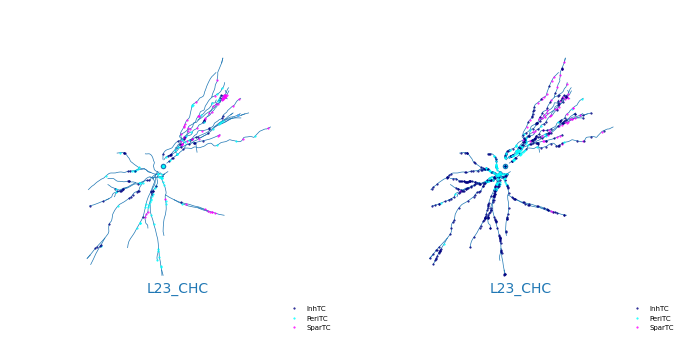

dict_keys(['PeriTC', 'InhTC', 'SparTC'])


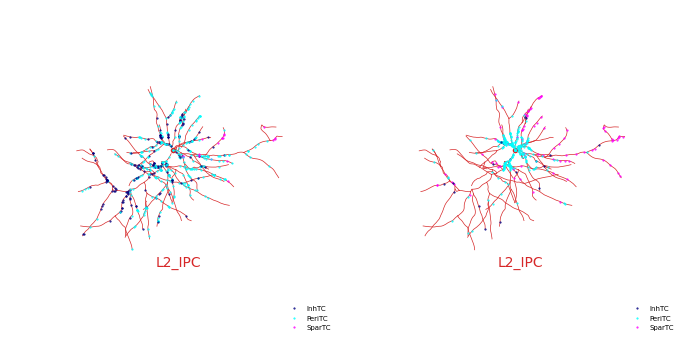

dict_keys(['PeriTC', 'InhTC', 'SparTC'])


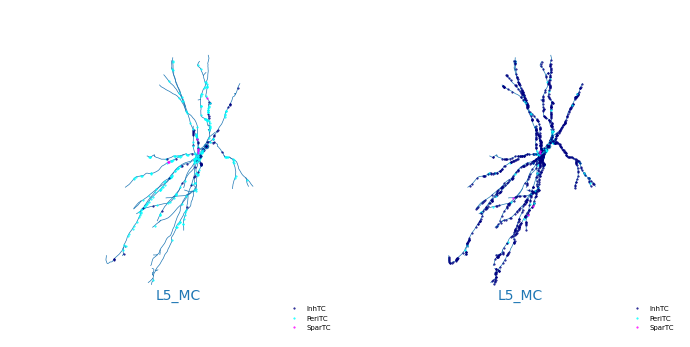

dict_keys(['PeriTC', 'InhTC'])


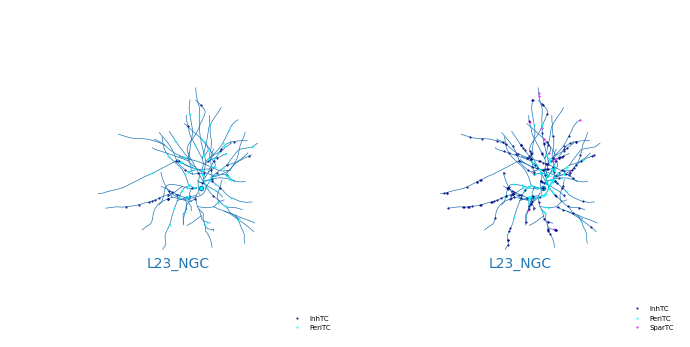

dict_keys(['PeriTC', 'InhTC'])


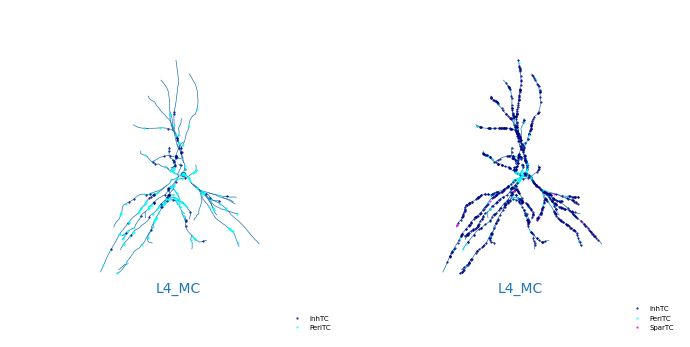

dict_keys(['PeriTC', 'InhTC'])
dict_keys(['PeriTC', 'InhTC', 'SparTC'])


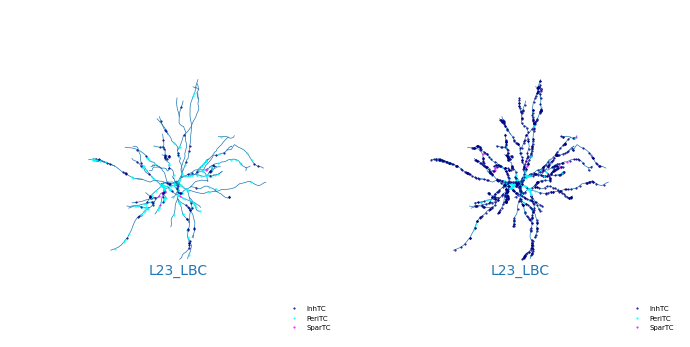

dict_keys(['PeriTC', 'InhTC'])


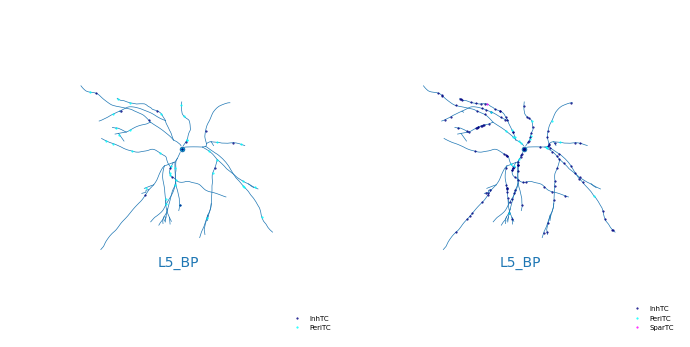

dict_keys(['InhTC', 'PeriTC'])


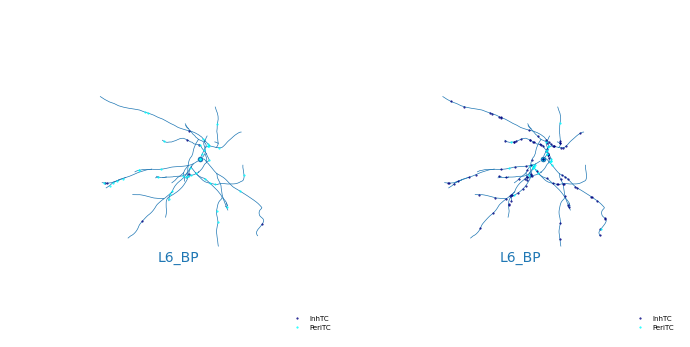

dict_keys(['SparTC', 'PeriTC'])


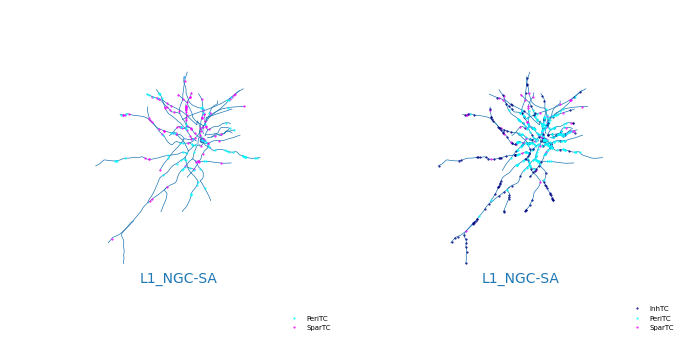

dict_keys(['PeriTC', 'InhTC', 'SparTC'])


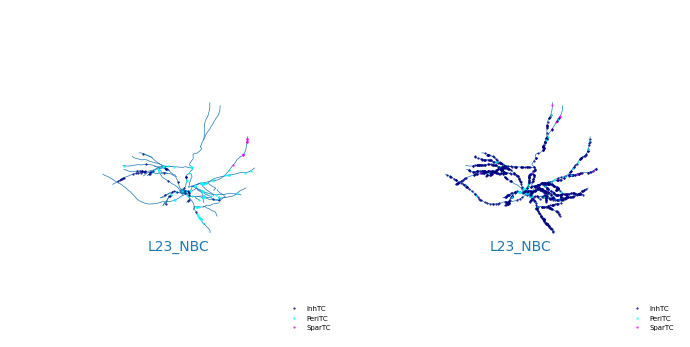

dict_keys(['SparTC', 'PeriTC', 'InhTC'])


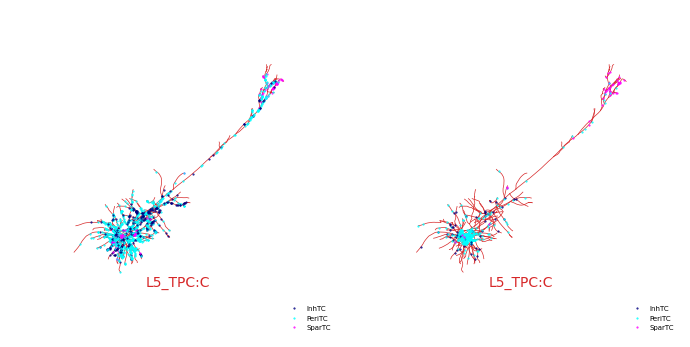

dict_keys(['SparTC', 'PeriTC', 'InhTC'])


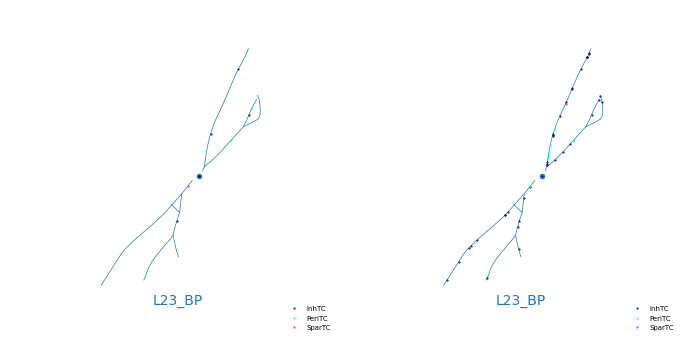

dict_keys(['SparTC', 'PeriTC', 'InhTC'])


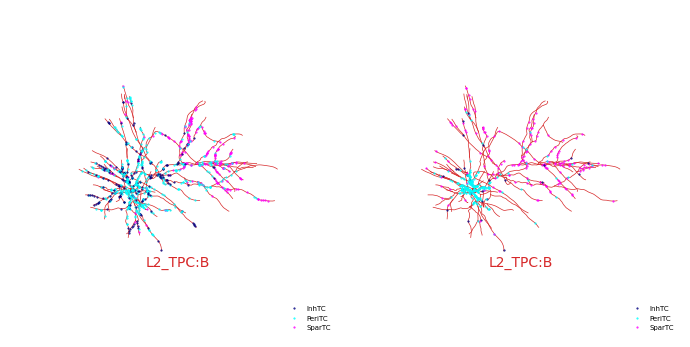

dict_keys(['PeriTC', 'InhTC', 'SparTC'])
dict_keys(['InhTC', 'PeriTC', 'SparTC'])


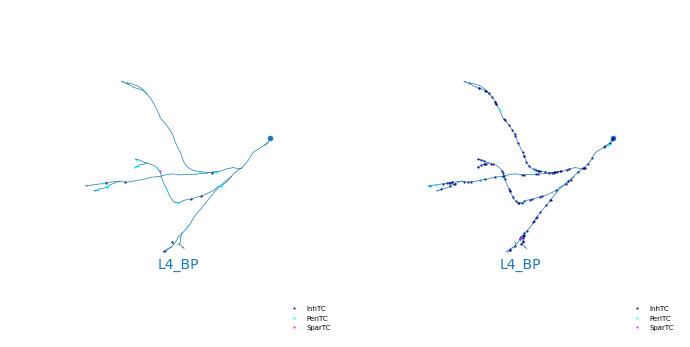

dict_keys(['PeriTC', 'InhTC'])
dict_keys(['InhTC', 'PeriTC'])
dict_keys(['InhTC', 'PeriTC'])


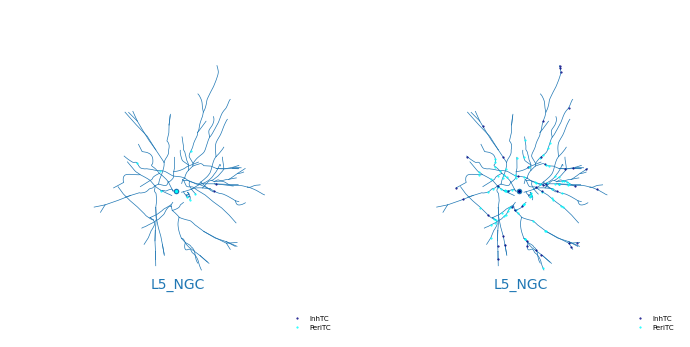

dict_keys(['SparTC', 'PeriTC', 'InhTC'])


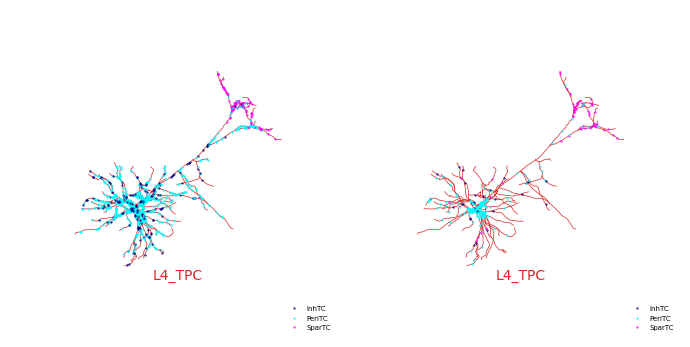

dict_keys(['SparTC', 'PeriTC', 'InhTC'])


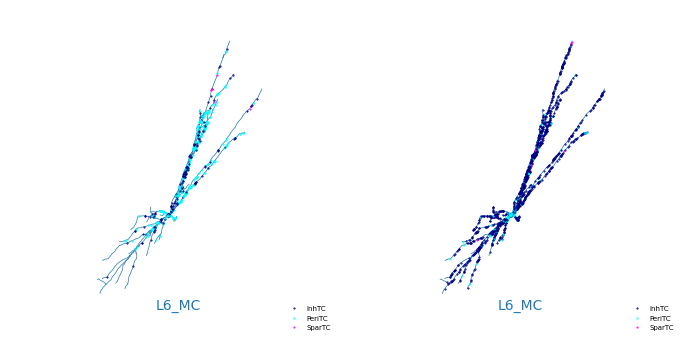

dict_keys(['PeriTC', 'InhTC'])


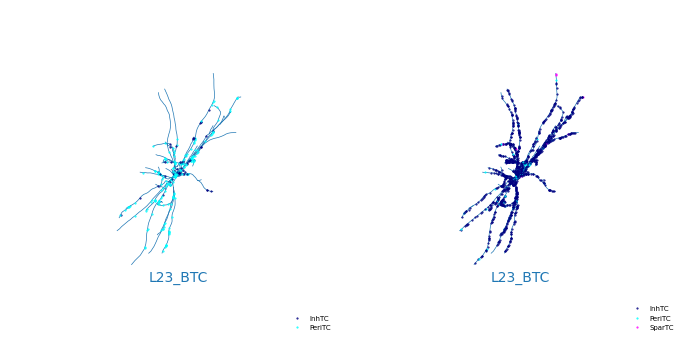

dict_keys(['SparTC', 'PeriTC', 'InhTC'])


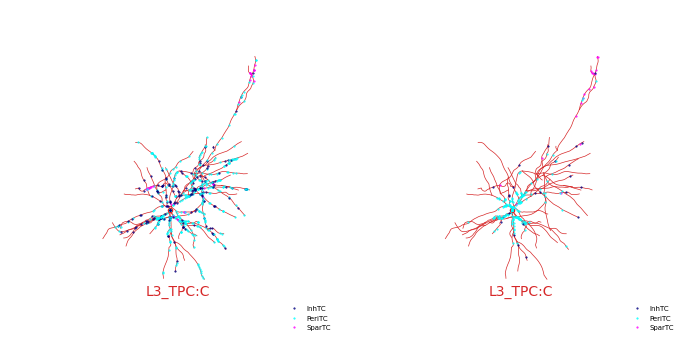

dict_keys(['InhTC', 'SparTC', 'PeriTC'])


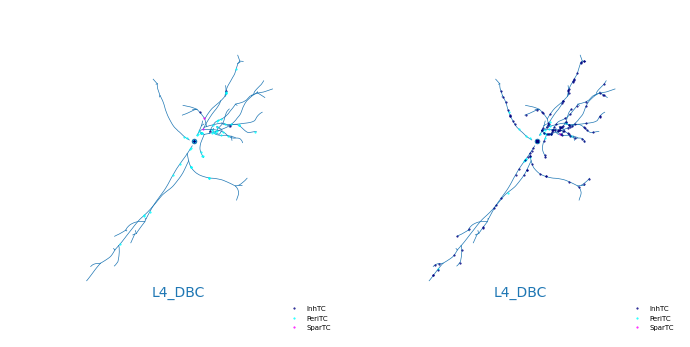

dict_keys(['SparTC', 'PeriTC', 'InhTC'])


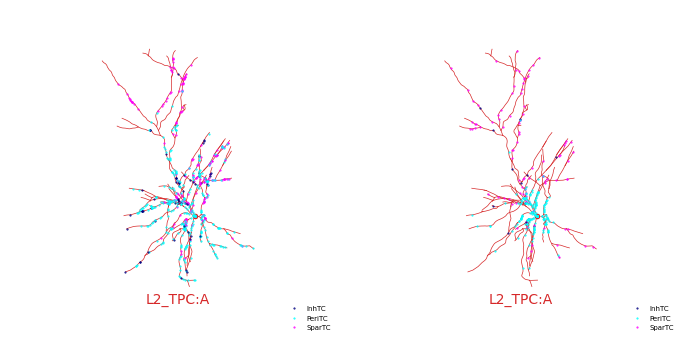

dict_keys(['SparTC', 'PeriTC', 'InhTC'])


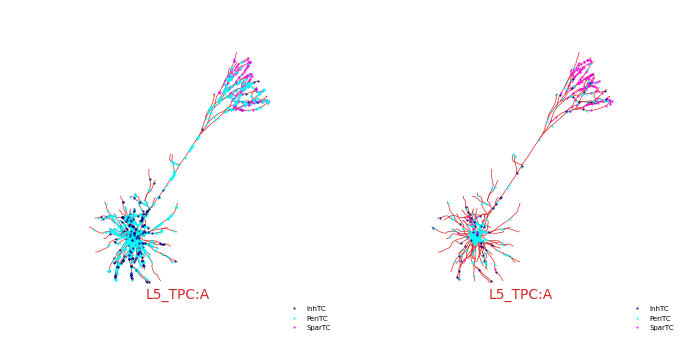

dict_keys(['SparTC', 'PeriTC', 'InhTC'])


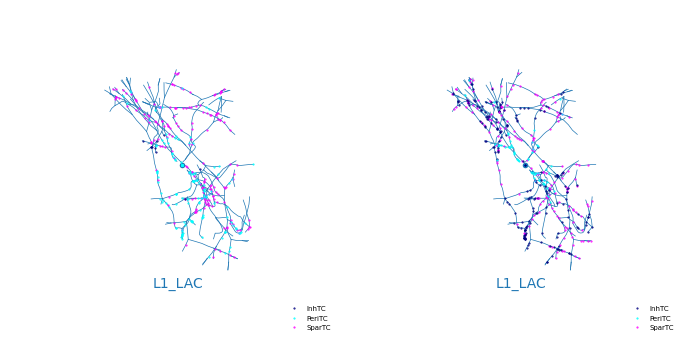

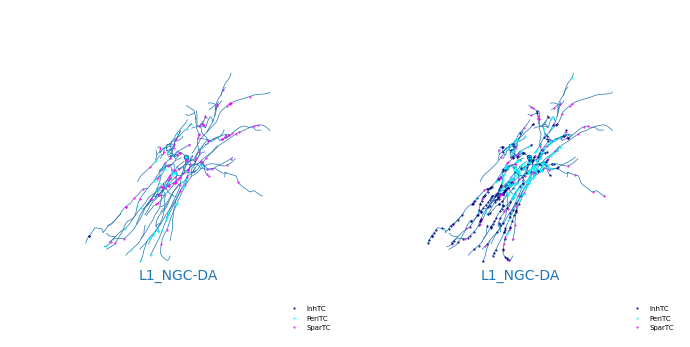

dict_keys(['PeriTC', 'SparTC', 'InhTC'])


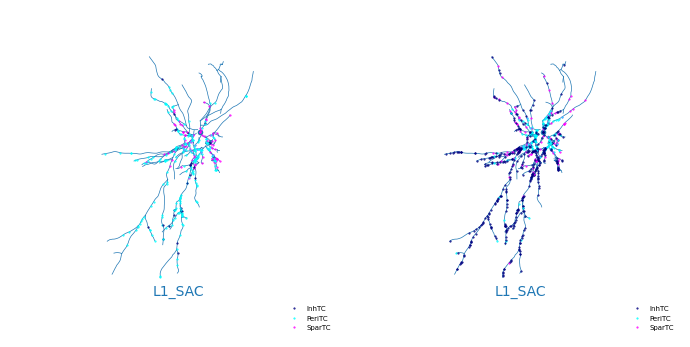

dict_keys(['SparTC', 'PeriTC', 'InhTC'])


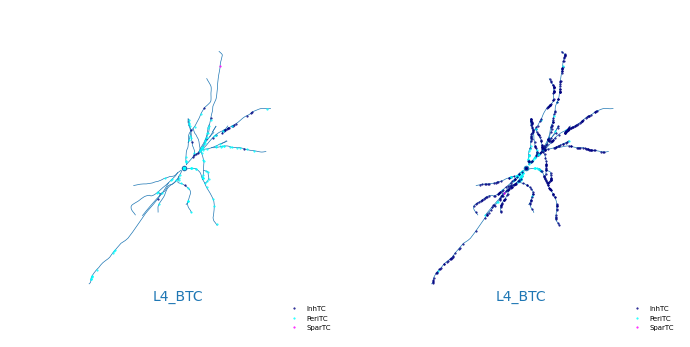

dict_keys(['SparTC', 'PeriTC', 'InhTC'])


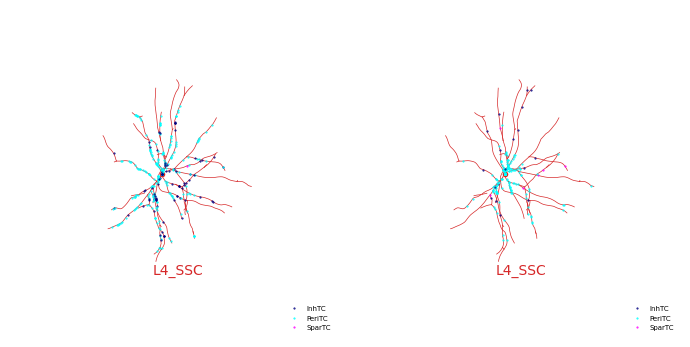

dict_keys(['InhTC', 'PeriTC'])


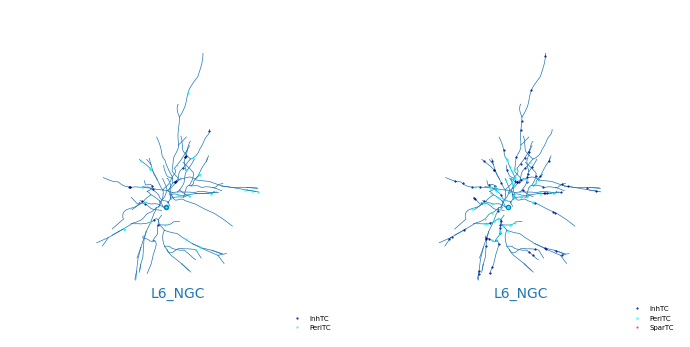

dict_keys(['SparTC', 'InhTC', 'PeriTC'])
dict_keys(['SparTC', 'PeriTC', 'InhTC'])


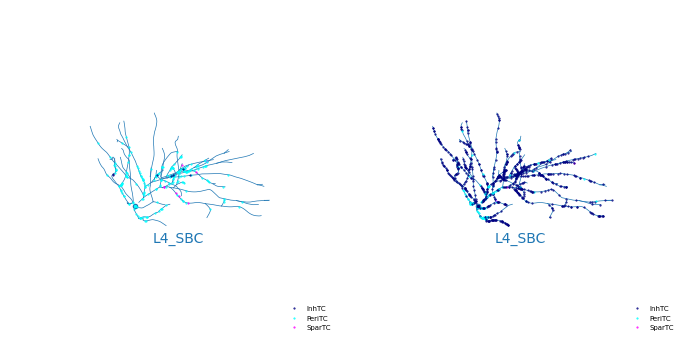

dict_keys(['SparTC', 'PeriTC', 'InhTC'])


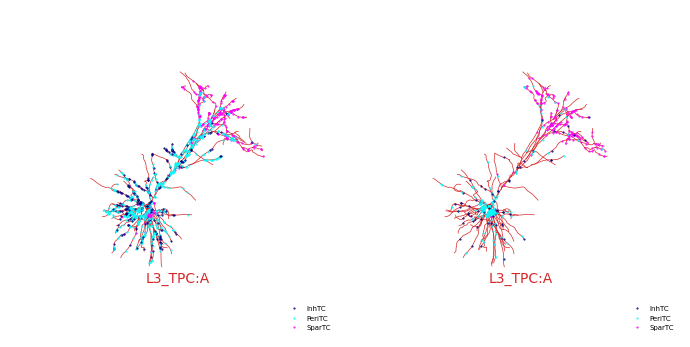

dict_keys(['SparTC', 'PeriTC', 'InhTC'])
dict_keys(['SparTC', 'PeriTC', 'InhTC'])


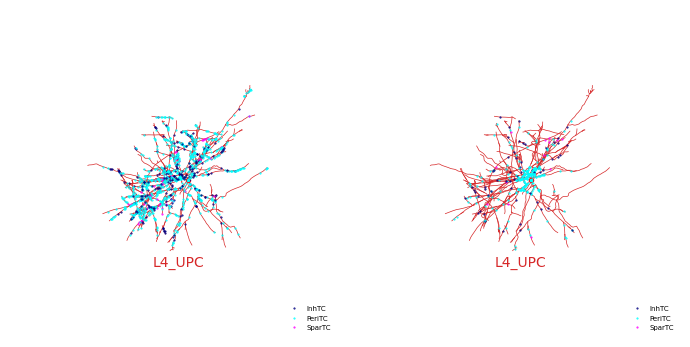

dict_keys(['InhTC', 'PeriTC'])


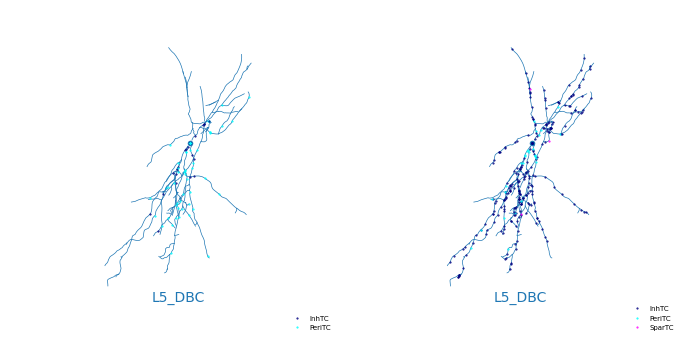

dict_keys(['SparTC', 'PeriTC', 'InhTC'])


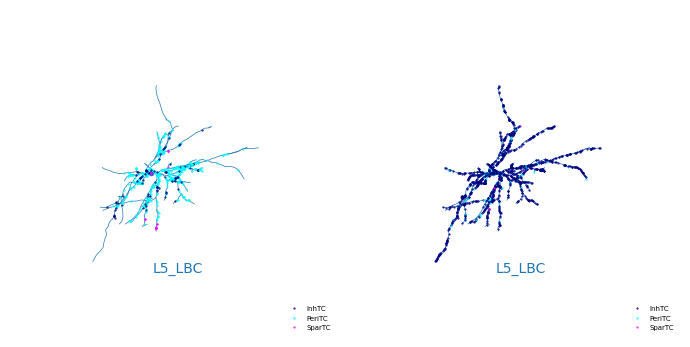

dict_keys(['SparTC', 'PeriTC', 'InhTC'])


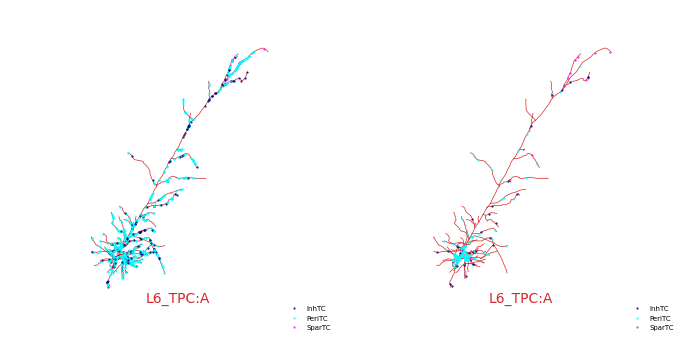

dict_keys(['PeriTC', 'InhTC'])


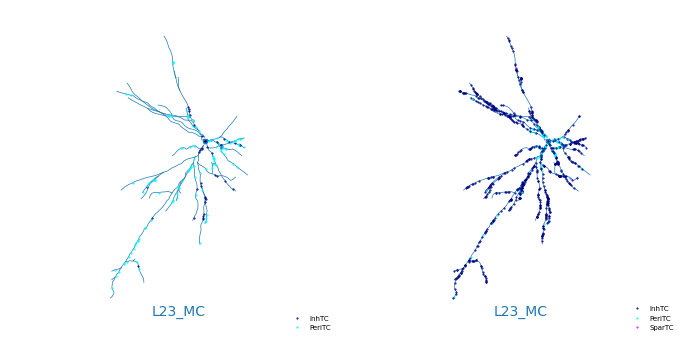

dict_keys(['InhTC', 'PeriTC'])


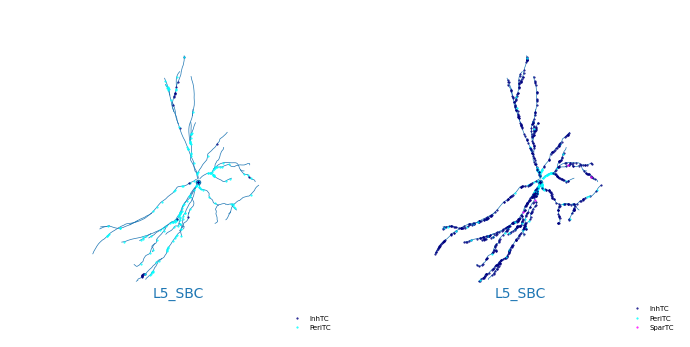

dict_keys(['InhTC', 'PeriTC'])


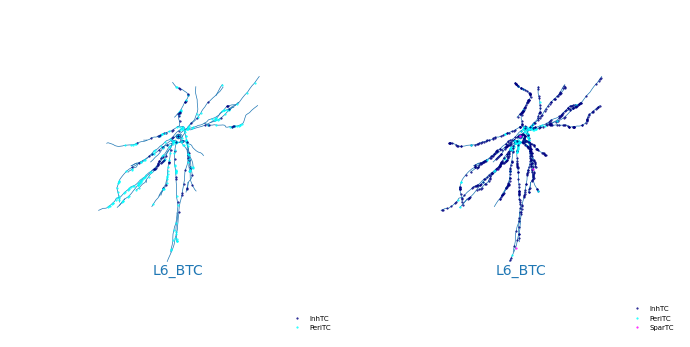

dict_keys(['PeriTC', 'InhTC'])
dict_keys(['InhTC', 'SparTC', 'PeriTC'])


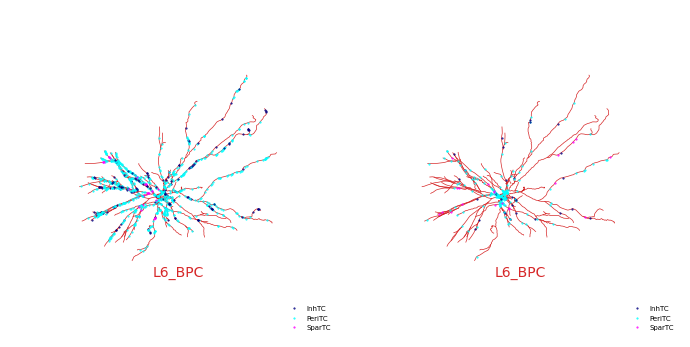

dict_keys(['SparTC', 'PeriTC', 'InhTC'])


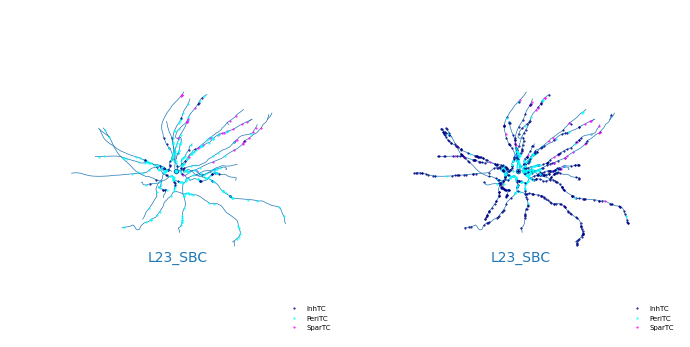

dict_keys(['InhTC', 'PeriTC'])
dict_keys(['InhTC', 'SparTC', 'PeriTC'])


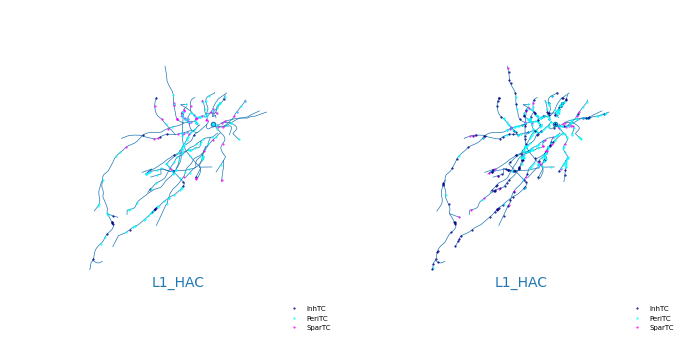

dict_keys(['PeriTC', 'InhTC', 'SparTC'])
dict_keys(['PeriTC', 'InhTC'])


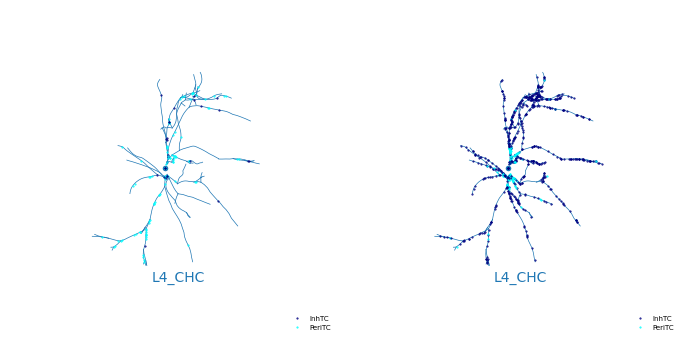

dict_keys(['InhTC', 'PeriTC'])


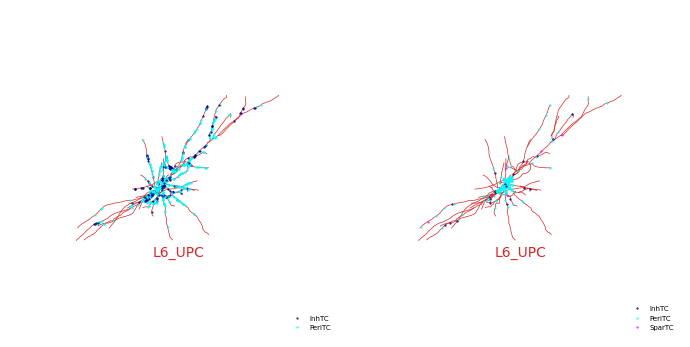

dict_keys(['PeriTC', 'InhTC'])
dict_keys(['PeriTC', 'InhTC'])


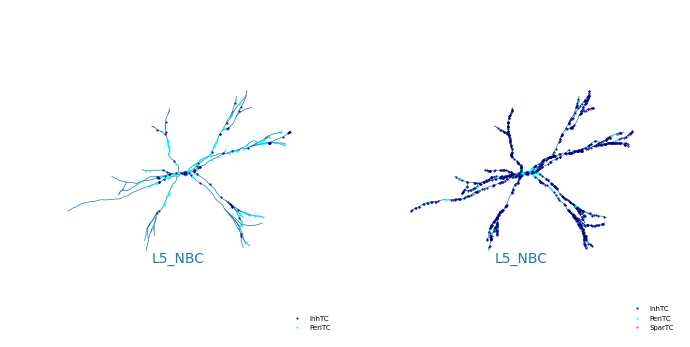

dict_keys(['InhTC', 'PeriTC'])


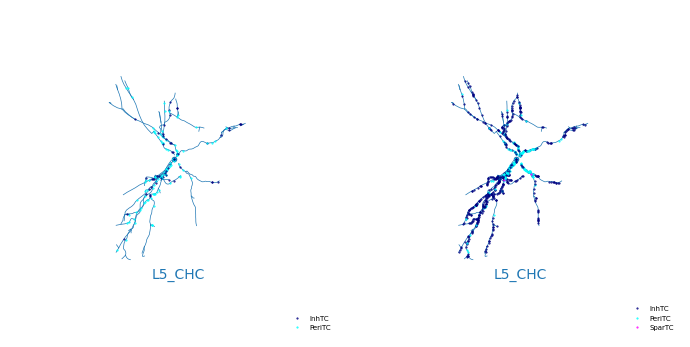

dict_keys(['SparTC', 'PeriTC', 'InhTC'])


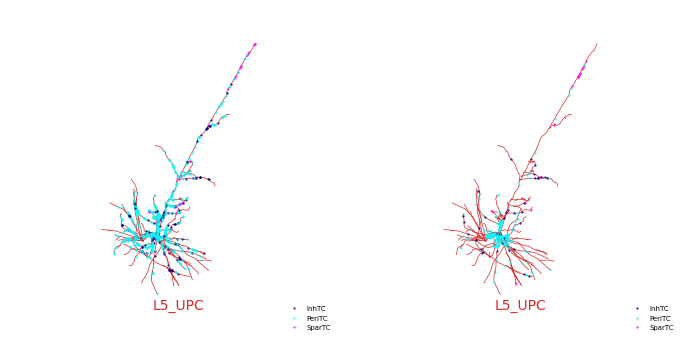

dict_keys(['InhTC', 'PeriTC'])


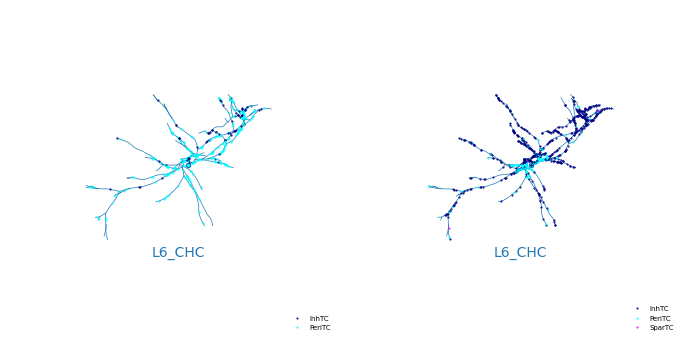

dict_keys(['PeriTC', 'InhTC', 'SparTC'])


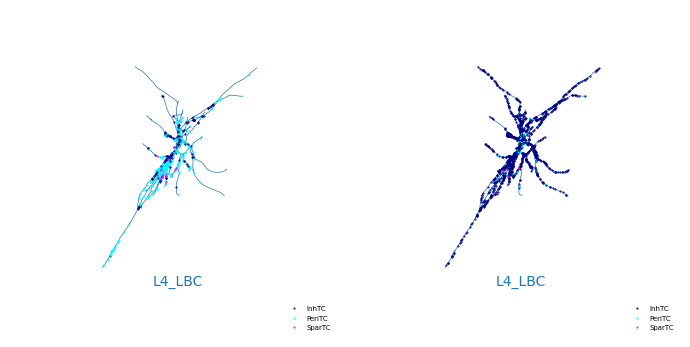

dict_keys(['InhTC', 'PeriTC', 'SparTC'])


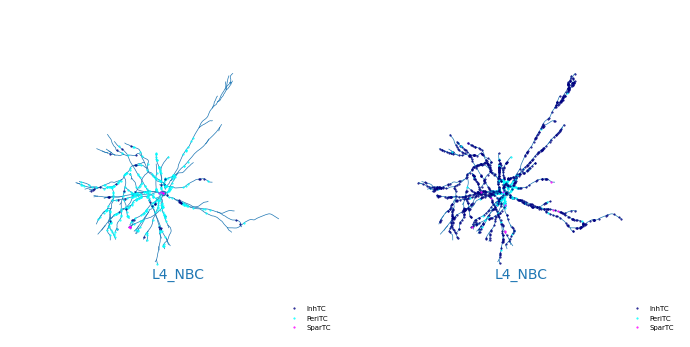

dict_keys(['SparTC', 'PeriTC', 'InhTC'])


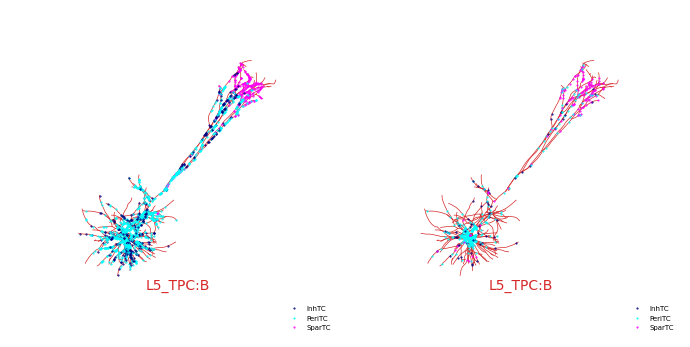

dict_keys(['InhTC', 'PeriTC', 'SparTC'])


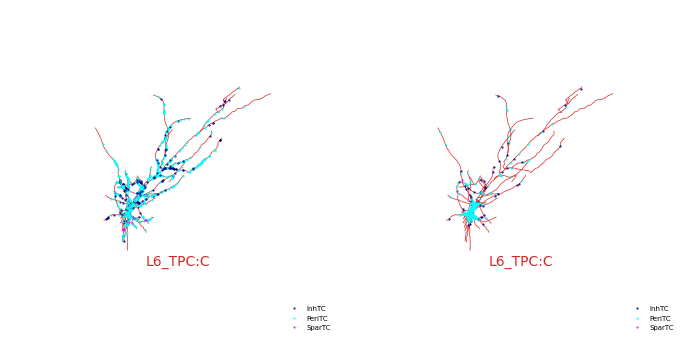

In [11]:
# Plot morphologies
for _idx, tid in enumerate(tid_list):  # One selected node ID for all m-types
    orig_edges_table, sm_edges_table = load_edges_tables(edges, sm_edges, src_nids, tid)
    soma_pos, dd_points = load_morphology(nodes, tid)
    plot_syn_on_morph(nodes, soma_pos, dd_points, src_nids, tid, orig_edges_table, sm_edges_table, figs_path, fn_prefix=f'{_idx + 1:02d}_')